In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib as plt
from itertools import chain
import ast

In [2]:
df = pd.read_csv("full_set.csv")
df.shape

(588793, 31)

In [3]:
TARGET_CLASS = "CHM2210"

In [4]:
# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

In [5]:
# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes
127,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]"
128,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101]
129,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]"
130,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]"


In [6]:
# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename(f'{TARGET_CLASS}_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df[f'{TARGET_CLASS}_Semester']]

In [7]:
# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = [f'{TARGET_CLASS}_Points', f'{TARGET_CLASS}_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df[f'{TARGET_CLASS}_Grade'].isin(['WE', 'IF', 'W', 'WC'])]


In [8]:
display(df[df['Pidm'] ==  134328])
final_df = final_df[final_df['Semester'] < final_df[f'{TARGET_CLASS}_Semester']]
display(final_df[final_df['Pidm'] ==  134328])
groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    f'{TARGET_CLASS}_Grade': 'first',
    f'{TARGET_CLASS}_Points': 'first',
}).reset_index()

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,CHM2210_Semester
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708
3,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]",201708
4,134328,201808,3.0,1370.0,"[4.0, 0.0]","[A, S]","[80885.0, 89183.0]","[COP2510, EGN3000]",201708
5,134328,201901,3.0,1370.0,"[1.0, 0.0, 0.0]","[D, F, F]","[17655.0, 18741.0, 19361.0]","[COP3514, COT3100, CDA3103]",201708


,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,CHM2210_Semester,CHM2210_Points,CHM2210_Grade
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708,1.0,D
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708,1.0,D
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708,1.0,D


In [9]:
groupped_df.head(5)

,Pidm,HS GPA,Converted_SAT,Semester Grades,Semester Points,Classes,CRN,CHM2210_Grade,CHM2210_Points
0,134328,3.00,1370.0,"[C, B, A, B, A-]","[2.0, 3.0, 4.0, 3.0, 3.67]","[BSC2010L, BSC2010, ENC1101, PSY2012, ARC2211]","[11143.0, 23005.0, 11691.0, 52696.0, 52892.0]",D,1.00
1,706382,3.44,1280.0,"[A, A+, A, WC, WC, WC, WC, A, A]","[4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0]","[AMH2020, CHM2045, CHM2045L, CHM2046, CHM2046L...","[80953.0, 82346.0, 84033.0, 15234.0, 15241.0, ...",A,4.00
2,1085786,2.50,1180.0,"[B, A, B, B+, A, W, W, B-, A, B, D, A, B-, A, ...","[3.0, 4.0, 3.0, 3.33, 4.0, 0.0, 0.0, 2.67, 4.0...","[MAC2311, ECO2013, BSC2010, AMS4804, BSC2010L,...","[80534.0, 81300.0, 83081.0, 87275.0, 94320.0, ...",A-,3.67
3,1096567,3.85,1340.0,"[A-, A-, B-, W, A+, D, B, A+, B+, B, A, A+, A-...","[3.67, 3.67, 2.67, 0.0, 4.0, 1.0, 3.0, 4.0, 3....","[MAC1147, ENC1102, CHM2045, CHM2045L, SLS2901,...","[82970.0, 89553.0, 92762.0, 92839.0, 93253.0, ...",C,2.00
4,1302110,2.43,1040.0,[A],[4.0],[PCB3063],[54321.0],A+,4.00


In [10]:
all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

In [11]:
print(set(groupped_df["CHM2210_Grade"]))

{'A-', 'F', 'CF', 'CC-', 'CM', 'A+', 'F*', 'B+', 'A-*', 'C-', 'D*', 'B', 'C', 'S', 'C*', 'C+', 'D', 'FF', 'B-*', 'U', 'C-*', 'A', 'B-', 'D+', 'D-'}


In [12]:
print(groupped_df.shape)
display(groupped_df.head(3))

print(one_hot_df.shape)
display(one_hot_df.head(3))

(11781, 10)


,Pidm,HS GPA,Converted_SAT,Semester Grades,Semester Points,Classes,CRN,CHM2210_Grade,CHM2210_Points,One_Hot_Classes
0,134328,3.00,1370.0,"[C, B, A, B, A-]","[2.0, 3.0, 4.0, 3.0, 3.67]","[BSC2010L, BSC2010, ENC1101, PSY2012, ARC2211]","[11143.0, 23005.0, 11691.0, 52696.0, 52892.0]",D,1.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,706382,3.44,1280.0,"[A, A+, A, WC, WC, WC, WC, A, A]","[4.0, 4.0, 4.0, 0.0, 0.0, 0.0, 0.0, 4.0, 4.0]","[AMH2020, CHM2045, CHM2045L, CHM2046, CHM2046L...","[80953.0, 82346.0, 84033.0, 15234.0, 15241.0, ...",A,4.00,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,1085786,2.50,1180.0,"[B, A, B, B+, A, W, W, B-, A, B, D, A, B-, A, ...","[3.0, 4.0, 3.0, 3.33, 4.0, 0.0, 0.0, 2.67, 4.0...","[MAC2311, ECO2013, BSC2010, AMS4804, BSC2010L,...","[80534.0, 81300.0, 83081.0, 87275.0, 94320.0, ...",A-,3.67,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


(11781, 1524)


,ACG2021,ACG2071,ACG3074,ACG3103,ACG3113,ACG3341,ACG3401,ACG4123,ACG4632,ACG4684,ACG5205,ADV2214,ADV3008,AFA2000,AFA2380,AFA3110,AFA4150,AFA4335,AFA4430,AFA4931,AFH3100,AFH3200,AFR1101,AFR1120,AFR2001,AFR2130,AFR2140,AFR3220,AFR3231,AFR4201,AFS2250,AMH2010,AMH2020,AMH3130,AMH3140,AMH3160,AMH3170,AMH3270,AMH3390,AMH3402,AMH3403,AMH3421,AMH3423,AMH3533,AMH3545,AMH3571,AMH3572,AML3031,AML3051,AML3243,AML3604,AML3630,AML3674,AML4111,AMS2030,AMS2270,AMS3700,AMS3930,AMS4804,ANS3006,ANT2000,ANT2410,ANT2464,ANT2511,ANT2511L,ANT2721,ANT3005,ANT3101,ANT3610,ANT4012,ANT4034,ANT4167,ANT4241,ANT4302,ANT4316,ANT4401,ANT4403,ANT4442,ANT4462,ANT4465,ANT4468,ANT4516,ANT4520C,ANT4525,ANT4532,ANT4536,ANT4593,ANT4701,ANT4750,ANT4824,ANT4905,ANT4930,APK3120,APK4138C,APK6109,APK6511,APK6902,ARA1120,ARA1121,ARC2112L,ARC2131C,ARC2135C,ARC2180,ARC2211,ARC2701,ARC2702,ARC2931,ARC4784,ARC5361,ARC5362,ARC5470,ARC5587,ARC5732,ARC5931,ARH2000,ARH2050,ARH2051,ARH3001,ARH4301,ARH4333,ARH4450,ARH4890,ARH4930,ART2201C,ART2203C,ART2301C,ART2344,ART2500C,ART2701C,ART2750C,ART2930,ART3530C,ART3612C,ART3616C,ART4814,ART4905,ART4930,ART4940,ASL2140C,ASL2150C,ASL3514,ASL4161C,ASL4201C,ASL4301C,ASN3012,ASN3014,ASN3030,ASN3201,ASN4414,AST2002,AST2003,AST2004,AST3033,AST3044,AST3930,ATR1000,ATR2010C,ATR3132,BCH3023L,BCH3053,BCH4033,BME3053,BME4100,BME4406,BME4503,BME4508,BME4571,BME4914,BME4931,BME4943,BOT3015C,BOT3152C,BOT3850,BOT4404C,BOT4714C,BOT4851,BSC1005,BSC1020,BSC2010,BSC2010L,BSC2011,BSC2011L,BSC2050,BSC2085,BSC2085L,BSC2086,BSC2086L,BSC2093C,BSC2094C,BSC2932,BSC3022,BSC3312,BSC3368C,BSC3402L,BSC3453,BSC3848,BSC4052,BSC4057,BSC4313C,BSC4315,BSC4333,BSC4444,BSC4454C,BSC4511,BSC4905,BSC4910,BSC4933,BSC4940,BUL3320,CBH4004,CCJ3014,CCJ3024,CCJ3026,CCJ3058,CCJ3117,CCJ3120,CCJ3621,CCJ3632,CCJ3644,CCJ3666,CCJ3701,CCJ3718,CCJ4072,CCJ4361,CCJ4487,CCJ4604,CCJ4613,CCJ4651,CCJ4662,CCJ4681,CCJ4930,CCJ4933,CCJ4934,CDA3103,CDA3201,CDA3201L,CEN3722,CGN4122,CGN4905,CGN4933,CGS1540,CGS2034,CGS2060,CGS2094,CGS2100,CGS3303,CGS3853,CHI1100,CHI1120,CHI1121,CHI1955,CHI2220,CHI2221,CHI3241,CHI3242,CHI4930,CHM2020,CHM2023,CHM2045,CHM2045L,CHM2046,CHM2046L,CHM2210L,CHM2211,CHM3080,CHM3120C,CHM3415C,CHM3610,CHM3610L,CHM3941,CHM4060,CHM4070,CHM4410,CHM4932,CHM4970,CHS2440,CHS2440L,CHS4411,CHT3512,CIS3213,CIS3360,CIS3362,CIS3433,CIS3615,CIS4083,CIS4204,CJC4010,CJE3213,CJE3444,CJE3650,CJE3656,CJE3701,CJE4010,CJE4114,CJE4731,CJL3110,CJL3502,CJL4115,CJL4410,CLA3103,CLA3124,CLA3503,CLA3930,CLP4134,CLP4143,CLP4314,CLP4414,CLP4433,CLP4941,CLT3040,CLT3103,CLT3123,CLT3370,CNT4104,CNT4104L,CNT4403,CNT4603,COM2000,COM2130,COM3014,COM3122,COM4022,COM4027,COM4030,COM4374,COP2030,COP2250,COP2510,COP2512,COP2513,COP2931,COP3331,COP3353,COP3514,COP3515,COP4313,COP4530,COP4538,COP4703,COP4931,COT3100,CPO2002,CPO4034,CPO4930,CRW2100,CRW3013,CRW3111,CRW3112,CRW3121,CRW3311,CRW3312,CRW3321,CRW4930,DAA2100,DAA2104,DAA2200,DAA2204,DAA2500,DAA3108,DAA3209,DAA3214,DAA3294,DAA3395,DAA3614,DAA3615,DAA3624,DAA4211,DAN2100,DAN2160,DAN3584,DAN3615,DAN3714,DAN4134,DAN4434,DAN4906,DEP2004,DEP4053,DEP4220,DIG3950C,ECH3002,ECH3023,ECH3101,ECH3240L,ECH3266,ECH3702,ECH3783,ECH3854,ECH4123,ECH4241L,ECH4267,ECH4323,ECH4418,ECH4504,ECH4605,ECH4615,ECH4615C,ECH4680C,ECH4715,ECH4783,ECH4846,ECH4905,ECH4931,ECH4936,ECH4944,ECO1000,ECO2013,ECO2023,ECO2052,ECO3101,ECO3203,ECO3703,ECO4303,ECO4400,ECO4914,ECO4935,ECP3302,ECP3530,ECS3013,ECS4003,EDE4223,EDE4323,EDE4504,EDE4941,EDF2005,EDF2085,EDF3132,EDF3214,EDF3228,EDF3514,EDF3604,EDF4124,EDF4430,EDF4440,EDF4490,EDF6211,EDG2930,EDG3361,EDG3801,EDG4012,EDG4909,EDP2210,EDP3273,EEE3302,EEE3394,EEE4506,EEL2161,EEL3472C,EEL3705,EEL3705L,EEL4705,EEL4935,EEL4936,EEL6935,EEX4012,EEX4070,EEX4742,EGN1113,EGN3000,EGN3000L,EGN3311,EGN3321,EGN3331,EGN3343,EGN3353,EGN3365,EGN3373,EGN3374,EGN3420,EGN3433,EGN3443,EGN3615,EGN3940,EGN4450,EGN4453,EGN4905,EGN4930,EGS2070,EGS3011,EGS3720,EIN4172,EIN4451,EIN4933,EMA4003,EME2040,EME4390,EML3022,EML3035,EML3041,EML3262,EML3303,EML3500,EML3701,EML4106C,E

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create a binary target column based on CHM2210_Grade
# Define passing grades (modify this list if necessary)
passing_grades = ['A', 'A+', 'A-', 'B', 'B+', 'B-', 'C', 'C+', 'C-', 'S']

# Add a new column 'CHM2210_pass' indicating if the student passed (1) or failed (0)
groupped_df['CHM2210_pass'] = groupped_df['CHM2210_Grade'].apply(lambda x: 1 if x in passing_grades else 0)

# Split the dataset into 80% training, 10% development, and 10% test sets
train_df, temp_df = train_test_split(one_hot_df, train_size=0.8, random_state=50)
dev_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=50)

# Ensure 'CHM2210_pass' is included in the training, dev, and test sets
train_df = train_df.merge(groupped_df[['Pidm', 'CHM2210_pass']], on='Pidm')
dev_df = dev_df.merge(groupped_df[['Pidm', 'CHM2210_pass']], on='Pidm')
test_df = test_df.merge(groupped_df[['Pidm', 'CHM2210_pass']], on='Pidm')

# Split features and target for training, dev, and test sets
X_train = train_df.drop(columns=['Pidm', 'CHM2210_pass'])
y_train = train_df['CHM2210_pass']

X_dev = dev_df.drop(columns=['Pidm', 'CHM2210_pass'])
y_dev = dev_df['CHM2210_pass']

X_test = test_df.drop(columns=['Pidm', 'CHM2210_pass'])
y_test = test_df['CHM2210_pass']

# Train a decision tree classifier
clf = DecisionTreeClassifier(random_state=50)
clf.fit(X_train, y_train)

# Make predictions on the development set
y_dev_pred = clf.predict(X_dev)

# Evaluate the model
print("Development Set Performance:")
print("Accuracy:", accuracy_score(y_dev, y_dev_pred))
print(classification_report(y_dev, y_dev_pred))

# Make predictions on the test set
y_test_pred = clf.predict(X_test)

# Evaluate the model on the test set
print("Test Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Development Set Performance:
Accuracy: 0.8123938879456706
              precision    recall  f1-score   support

           0       0.28      0.29      0.28       153
           1       0.89      0.89      0.89      1025

    accuracy                           0.81      1178
   macro avg       0.59      0.59      0.59      1178
weighted avg       0.81      0.81      0.81      1178

Test Set Performance:
Accuracy: 0.8320610687022901
              precision    recall  f1-score   support

           0       0.28      0.26      0.27       140
           1       0.90      0.91      0.91      1039

    accuracy                           0.83      1179
   macro avg       0.59      0.58      0.59      1179
weighted avg       0.83      0.83      0.83      1179



In [20]:
from sklearn.model_selection import GridSearchCV

# Step 1: Define the parameter grid for tuning
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Step 2: Initialize the Decision Tree model
clf = DecisionTreeClassifier(random_state=50)

# Step 3: Set up GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, scoring='f1_weighted', n_jobs=-1, verbose=1)

# Step 4: Fit the model to the training data
grid_search.fit(X_train, y_train)

# Step 5: Get the best model based on the grid search
best_clf = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Step 6: Evaluate the best model on the development set
y_dev_pred = best_clf.predict(X_dev)
print("Development Set Performance after tuning:")
print("Accuracy:", accuracy_score(y_dev, y_dev_pred))
print(classification_report(y_dev, y_dev_pred))

# Step 7: Evaluate the best model on the test set
y_test_pred = best_clf.predict(X_test)
print("Test Set Performance after tuning:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best hyperparameters: {'class_weight': None, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Development Set Performance after tuning:
Accuracy: 0.8497453310696095
              precision    recall  f1-score   support

           0       0.33      0.15      0.21       153
           1       0.88      0.95      0.92      1025

    accuracy                           0.85      1178
   macro avg       0.61      0.55      0.56      1178
weighted avg       0.81      0.85      0.82      1178

Test Set Performance after tuning:
Accuracy: 0.8608990670059372
              precision    recall  f1-score   support

           0       0.30      0.13      0.18       140
           1       0.89      0.96      0.92      1039

    accuracy                           0.86      1179
   macro avg       0.60      0.54      0.55      1179
weighted avg       0.82      0.86      0.84      1179



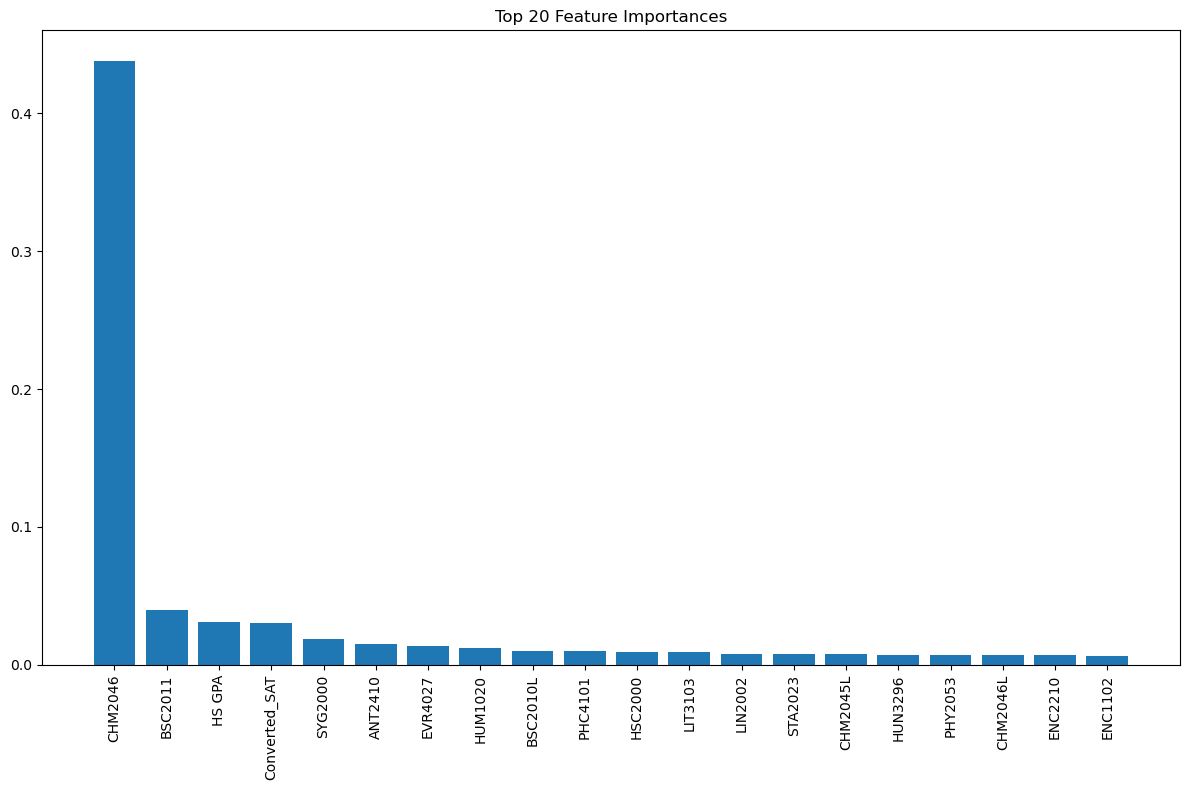

Top 20 Features and Their Importances:
CHM2046: 0.4381
BSC2011: 0.0395
HS GPA: 0.0310
Converted_SAT: 0.0307
SYG2000: 0.0190
ANT2410: 0.0151
EVR4027: 0.0138
HUM1020: 0.0119
BSC2010L: 0.0101
PHC4101: 0.0098
HSC2000: 0.0094
LIT3103: 0.0091
LIN2002: 0.0081
STA2023: 0.0077
CHM2045L: 0.0076
HUN3296: 0.0072
PHY2053: 0.0070
CHM2046L: 0.0070
ENC2210: 0.0070
ENC1102: 0.0068


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the best model
feature_importances = best_clf.feature_importances_

# Get the feature names (column names from the training data)
feature_names = X_train.columns

# Sort the feature importances in descending order and select the top 20
indices = np.argsort(feature_importances)[::-1][:20]

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.title("Top 20 Feature Importances")
plt.bar(range(len(indices)), feature_importances[indices], align='center')
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Optionally, print the top features with their importance scores
top_features = [(feature_names[i], feature_importances[i]) for i in indices]
print("Top 20 Features and Their Importances:")
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Create a binary target column based on CHM2210_Grade
# Define passing grades (modify this list if necessary)
passing_grades = ['A', 'A+', 'A-', 'B', 'B+', 'B-', 'C', 'C+', 'C-', 'S']

# Add a new column 'CHM2210_pass' indicating if the student passed (1) or failed (0)
groupped_df['CHM2210_pass'] = groupped_df['CHM2210_Grade'].apply(lambda x: 1 if x in passing_grades else 0)

# Fill missing values in HS GPA and Converted_SAT with the median value
groupped_df['HS GPA'] = groupped_df['HS GPA'].fillna(groupped_df['HS GPA'].median())
groupped_df['Converted_SAT'] = groupped_df['Converted_SAT'].fillna(groupped_df['Converted_SAT'].median())

# Merge HS GPA and Converted_SAT into one_hot_df
one_hot_df = one_hot_df.merge(groupped_df[['Pidm', 'HS GPA', 'Converted_SAT']], on='Pidm')

# Split the dataset into 80% training, 10% development, and 10% test sets
train_df, temp_df = train_test_split(one_hot_df, train_size=0.8, random_state=50)
dev_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=50)

# Ensure 'CHM2210_pass' is included in the training, dev, and test sets
train_df = train_df.merge(groupped_df[['Pidm', 'CHM2210_pass']], on='Pidm')
dev_df = dev_df.merge(groupped_df[['Pidm', 'CHM2210_pass']], on='Pidm')
test_df = test_df.merge(groupped_df[['Pidm', 'CHM2210_pass']], on='Pidm')

# Split features and target for training, dev, and test sets
X_train = train_df.drop(columns=['Pidm', 'CHM2210_pass'])
y_train = train_df['CHM2210_pass']

X_dev = dev_df.drop(columns=['Pidm', 'CHM2210_pass'])
y_dev = dev_df['CHM2210_pass']

X_test = test_df.drop(columns=['Pidm', 'CHM2210_pass'])
y_test = test_df['CHM2210_pass']

# Train a decision tree classifier
clf = DecisionTreeClassifier(random_state=50)
clf.fit(X_train, y_train)

# Make predictions on the development set
y_dev_pred = clf.predict(X_dev)

# Evaluate the model
print("Development Set Performance:")
print("Accuracy:", accuracy_score(y_dev, y_dev_pred))
print(classification_report(y_dev, y_dev_pred))

# Make predictions on the test set
y_test_pred = clf.predict(X_test)

# Evaluate the model on the test set
print("Test Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Development Set Performance:
Accuracy: 0.8123938879456706
              precision    recall  f1-score   support

           0       0.28      0.29      0.28       153
           1       0.89      0.89      0.89      1025

    accuracy                           0.81      1178
   macro avg       0.59      0.59      0.59      1178
weighted avg       0.81      0.81      0.81      1178

Test Set Performance:
Accuracy: 0.8320610687022901
              precision    recall  f1-score   support

           0       0.28      0.26      0.27       140
           1       0.90      0.91      0.91      1039

    accuracy                           0.83      1179
   macro avg       0.59      0.58      0.59      1179
weighted avg       0.83      0.83      0.83      1179



In [16]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25],  # Control the depth of the tree
    'min_samples_split': [2, 5, 10, 15],    # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],       # Minimum number of samples required to be at a leaf node
    'criterion': ['gini', 'entropy']        # The function to measure the quality of a split
}

# Initialize a decision tree classifier
clf = DecisionTreeClassifier(random_state=50)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Fit the model using the training data
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_clf = grid_search.best_estimator_

# Output the best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Make predictions on the development set using the tuned model
y_dev_pred = best_clf.predict(X_dev)

# Evaluate the model performance on the development set
print("Development Set Performance After Tuning:")
print("Accuracy:", accuracy_score(y_dev, y_dev_pred))
print(classification_report(y_dev, y_dev_pred))

# Make predictions on the test set
y_test_pred = best_clf.predict(X_test)

# Evaluate the tuned model performance on the test set
print("Test Set Performance After Tuning:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2}
Development Set Performance After Tuning:
Accuracy: 0.870118845500849
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.87      1.00      0.93      1025

    accuracy                           0.87      1178
   macro avg       0.44      0.50      0.47      1178
weighted avg       0.76      0.87      0.81      1178

Test Set Performance After Tuning:
Accuracy: 0.8812553011026294
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       140
           1       0.88      1.00      0.94      1039

    accuracy                           0.88      1179
   macro avg       0.44      0.50      0.47      1179
weighted avg       0.78      0.88      0.83      1179



d:\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\New folder\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetric

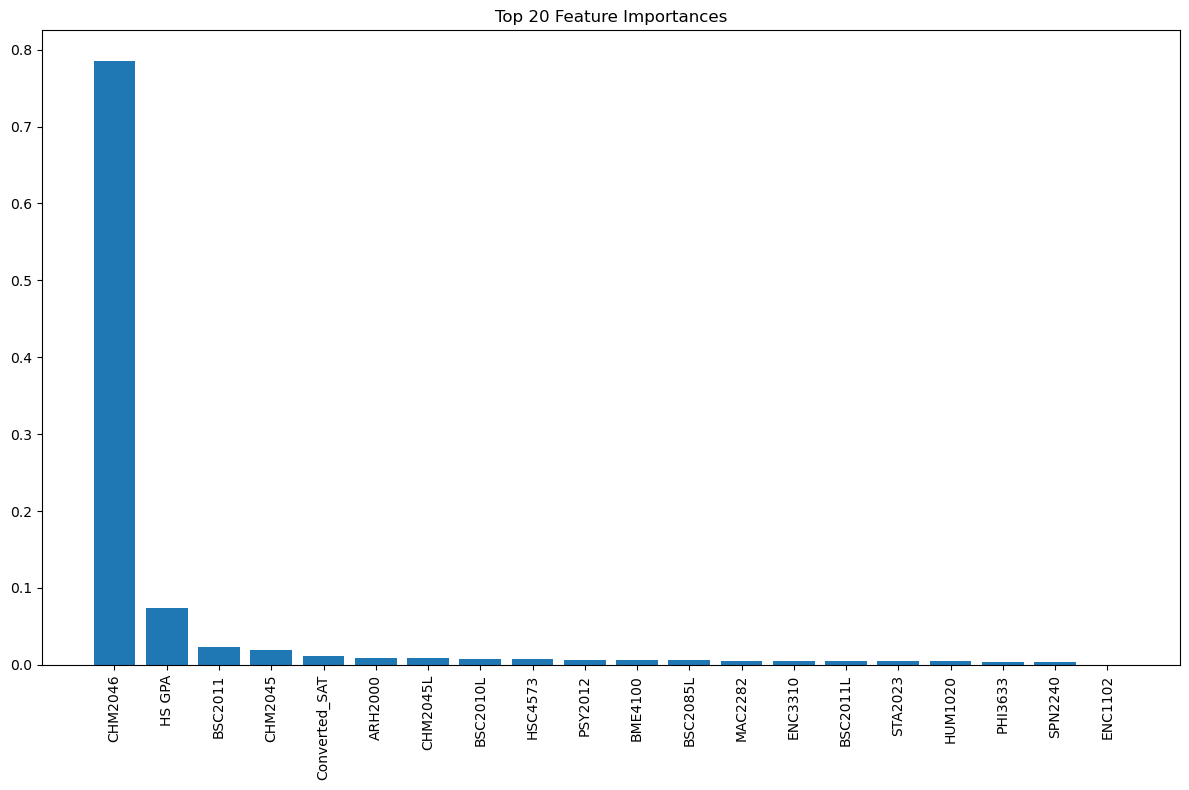

Top 20 Features and Their Importances:
CHM2046: 0.7858
HS GPA: 0.0746
BSC2011: 0.0227
CHM2045: 0.0194
Converted_SAT: 0.0117
ARH2000: 0.0095
CHM2045L: 0.0093
BSC2010L: 0.0079
HSC4573: 0.0078
PSY2012: 0.0067
BME4100: 0.0060
BSC2085L: 0.0058
MAC2282: 0.0056
ENC3310: 0.0053
BSC2011L: 0.0050
STA2023: 0.0048
HUM1020: 0.0044
PHI3633: 0.0042
SPN2240: 0.0035
ENC1102: 0.0000


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the best model
feature_importances = best_clf.feature_importances_

# Get the feature names (column names from the training data)
feature_names = X_train.columns

# Sort the feature importances in descending order and select the top 20
indices = np.argsort(feature_importances)[::-1][:20]

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
plt.title("Top 20 Feature Importances")
plt.bar(range(len(indices)), feature_importances[indices], align='center')
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# Optionally, print the top features with their importance scores
top_features = [(feature_names[i], feature_importances[i]) for i in indices]
print("Top 20 Features and Their Importances:")
for feature, importance in top_features:
    print(f"{feature}: {importance:.4f}")


In [18]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Threshold for feature importance (e.g., keep features with importance > 0.01)
importance_threshold = 0.01

# Get important features based on the threshold
important_features = [feature for feature, importance in zip(X_train.columns, best_clf.feature_importances_) 
                      if importance > importance_threshold]

# Include important features along with 'HS GPA' and 'Converted_SAT' if not already in the list
for feature in ['HS GPA', 'Converted_SAT']:
    if feature not in important_features:
        important_features.append(feature)

# Filter the training, development, and test sets to include only the important features
X_train_reduced = X_train[important_features]
X_dev_reduced = X_dev[important_features]
X_test_reduced = X_test[important_features]

# Optional: Create new interaction features based on high-importance features
X_train_reduced['CHM2046_HS_GPA'] = X_train['CHM2046'] * X_train['HS GPA']
X_dev_reduced['CHM2046_HS_GPA'] = X_dev['CHM2046'] * X_dev['HS GPA']
X_test_reduced['CHM2046_HS_GPA'] = X_test['CHM2046'] * X_test['HS GPA']

# Re-train the decision tree classifier with the reduced feature set
clf_reduced = DecisionTreeClassifier(random_state=50)
clf_reduced.fit(X_train_reduced, y_train)

# Evaluate the model on the development set
y_dev_pred_reduced = clf_reduced.predict(X_dev_reduced)
print("Development Set Performance (Reduced Features):")
print("Accuracy:", accuracy_score(y_dev, y_dev_pred_reduced))
print(classification_report(y_dev, y_dev_pred_reduced))

# Evaluate the model on the test set
y_test_pred_reduced = clf_reduced.predict(X_test_reduced)
print("Test Set Performance (Reduced Features):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_reduced))
print(classification_report(y_test, y_test_pred_reduced))

# Optionally, print the final important features used
print("Final Important Features Used for Training:")
print(important_features)


Development Set Performance (Reduced Features):
Accuracy: 0.7954159592529711
              precision    recall  f1-score   support

           0       0.23      0.24      0.23       153
           1       0.89      0.88      0.88      1025

    accuracy                           0.80      1178
   macro avg       0.56      0.56      0.56      1178
weighted avg       0.80      0.80      0.80      1178

Test Set Performance (Reduced Features):
Accuracy: 0.806615776081425
              precision    recall  f1-score   support

           0       0.23      0.27      0.25       140
           1       0.90      0.88      0.89      1039

    accuracy                           0.81      1179
   macro avg       0.57      0.58      0.57      1179
weighted avg       0.82      0.81      0.81      1179

Final Important Features Used for Training:
['BSC2011', 'CHM2045', 'CHM2046', 'HS GPA', 'Converted_SAT']


C:\Users\songt\AppData\Local\Temp\ipykernel_30540\1520659109.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_reduced['CHM2046_HS_GPA'] = X_train['CHM2046'] * X_train['HS GPA']
C:\Users\songt\AppData\Local\Temp\ipykernel_30540\1520659109.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_dev_reduced['CHM2046_HS_GPA'] = X_dev['CHM2046'] * X_dev['HS GPA']
C:\Users\songt\AppData\Local\Temp\ipykernel_30540\1520659109.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic